# Images clustering: Clustering images of human faces
Dranca Constantin

# I. Introduction
The clustering of images is a problem often approached in the field of unsupervised learning, the problem can be formulated like this, given a set of images, find clusters of images that are similar. In this notebook the problem of finding clusters of faces is approached with different unsupervised learning algorithms (like K-means, DBSCAN ...) applied on face embeddings obtained from images using deep neural networks trained in the scope of generating face embeddings from pictures.

<img src = 'https://drive.google.com/uc?id=1Jo_1mig2S9tcXFNNsBsWkRC8JeC6PSUa' width = 700> 

Figure 1.1. Example of clustering a set of images into two clusters, in each cluster are the images of the same person, image taken and processed from [4]

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from keras.models import load_model
from PIL import Image
from matplotlib import pyplot


This notebook was written in google colab, this is the reason why the google drive is mounted to the local working directory. In the case or running the notebook directly on PC then this cell doesn’t need to be executed and the root to the files must be set according to the file system of the PC.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# II. FairFace dataset
The dataset used for clustering is the FairFace dataset [3] introduced in the paper FairFace: Face Attribute Dataset for Balanced Race, Gender, and Age [1], it is a set with around 80000 images for train and 10000 images for test. For clustering it was used the train dataset. The faces are of various races, both genders and all ages. The faces are also varied in their pose, illumination and facial features. Images are with cropped faces, in RGB format and of size 224×224. 

The dataset can be downloaded from here: https://github.com/joojs/fairface, the version used here is the one with 0.25 padding in order to have images only with the human face and not the surounding background.

Below are some images from the dataset, the faces are exposed to different illuminations, various facial expressions, have different positions and angles, are varied across all ages from babies to old persons.

<img src = 'https://drive.google.com/uc?id=1dd6r5i4MCH-qr7slgxPvd5M2wSKGEvse' width = 400> 

Figure 2.2, Examples of images with faces from the FairFace dataset, images taken and processed from [3].

The dataset contains 7 classes of races: White, Black, Latino Hispanic, east Asian, southeast Asian, Indian, Middle Eastern. As stated in the paper, the classes are balanced, compared with other datasets.

<img src = 'https://drive.google.com/uc?id=1J3OBk1Gv3m1XMxNZffFatYzr51gKc5zL' width = 500> 

Figure 2.1, The distribution of the races from the FairFace dataset compared with other faces datasets, we can observe that the FairFace dataset have better balanced classes, image taken and processed from [1].

In [3]:
# Cell used to import data from drive and to unzip it, 
# data is in a .zip file
from zipfile import ZipFile

PATH_OF_FILE = 'gdrive/My Drive/fairface-img-margin025-trainval.zip'

print("Loading file")
with ZipFile(PATH_OF_FILE, 'r') as zipObj:
    print("Extracting")
    zipObj.extractall() 
print("Complete")

Loading file
Extracting
Complete


We will take a look also at the gender distribution and age distribution of the dataset

In [ ]:
files_df = pd.read_csv('gdrive/My Drive/fairface_label_train.csv')

nr_females = len(files_df.loc[files_df['gender'] == 'Female'])
nr_males = len(files_df.loc[files_df['gender'] == 'Male'])

print('Number of images with female person:', nr_females)
print('Number of images with male person:', nr_males)

hist_values = np.array([nr_females, nr_males])

pyplot.figure(figsize=(5, 5))
pyplot.bar(
    [1, 2], 
    hist_values, 
    width = 0.5,
    color = ['r', 'blue'], 
    edgecolor = 'black', 
    linewidth = 2
    )
pyplot.title("Gender distribution")
pyplot.ylabel("Number of images")
pyplot.xticks([1, 2], ['Females', 'Males'] )
pyplot.show()

After running the cell above the results show that there are 40758 images with female faces and 45986 images with male faces. In the case of the gender the dataset is balanced, as we can see from the following histogram.

<img src = 'https://drive.google.com/uc?id=1FkQ-idtLNnOWCkc_ezccEdND8ogfkvYb' width = 300> 

Figure 2.3. The gender distribution of the images from the FairFace dataset.

In [ ]:
ages = files_df['age'].to_numpy()

groups = np.array(
    ['0-2', 
     '3-9', 
     '10-19', 
     '20-29', 
     '30-39', 
     '40-49', 
     '50-59', 
     '60-69', 
     'more than 70'
     ])

group_nr_images = []

for group in groups:
    group_nr_images.append(np.count_nonzero(ages == group))

bins = np.arange(1, len(groups) + 1)

pyplot.figure(figsize=(8, 5))
pyplot.bar(
    bins, 
    group_nr_images, 
    width = 0.5,
    edgecolor = 'black', 
    linewidth = 2
    )
pyplot.title("Age distribution")
pyplot.ylabel("Number of images")
pyplot.xticks(bins, groups)
pyplot.show()

The images are grouped in 9 groups of age, the histogram of the age distribution of the dataset is shown below. As expected, in the case of using a continous variable for modeling the data, this age distribution tend to a normal distribution (this is probably due to the fact that is harder to obatin images with babies or old persons and the most present images accros the internet are with adult persons).

<img src = 'https://drive.google.com/uc?id=1EoR22h-QPMdEWGUtPmDUUFyQf-2NsEMA' width = 400>

Figure 2.4. The age distribution of the images from the FairFace dataset.

# III. Clustering approach

Applying directly the clustering algorithms on the images has some issues:


*   Because the dimensionality of the Euclidian space that the algorithm is applied is very large, images are of size 3×224×224 and to consider their vectorized format (from a 3D matrix to a 1D vector) we would obtain vectors in the euclidian space R^150528 which is a very large space, applying clustering algorithms on such a space with 80000 vectors would make the time execution explode.
*   The clustering algorithm doesn’t construct clusters based on semantic facial features (like nose form, skin color, eye color, type of hair) but on the raw values of the pixels, even the execution of the algorithm ends the clusters obtained could contain images with no underlying relation between them (image a cluster with 4 image: an old black man, a white baby, an Indian adult and an Asiatic child, the only relations between their faces are very general, all of them have one nose, two eyes, one mouth and so on).

To solve this issues we could use an algorithm implemented to extract a vector of features for every image. 

The approch used in this notebook is the following: 

*   Firstly, face embeddings must be extracted from images, for this it was used the FaceNet model [2] which is a convolutional neural network trained on millions of images with faces to extract face embeddings, a face embedding is a vector with 128 features than describe the face contained in the image. 
*   After the face embeddings are obtained, the new dataset with embeddings can be used for clustering with classical clustering algorithms (like K-means).

For more details about FaceNet model is found at [2]. The model can be downloaded from https://drive.google.com/drive/folders/1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn

<img src = 'https://drive.google.com/uc?id=16zlxI529IZkhpUj532uprzTJ5CDtgy0C' width = 400>

Figure 3.1, The structure of the approach.


# IV. Extract face embeddings with FaceNet

Every image is forwraded thorugh the FaceNet CNN and is obtained a vector with 128 features that can be used as a descriptor of the face contained in the image. All these embeddings are saved in a .csv file.

The csv files with already computed face embeddings can be downloaded from the link: https://drive.google.com/file/d/1aJ9KyXgUur2EG6DODsg4C5VooPvSEa8P/view?usp=sharing

In [ ]:
faceNet = load_model('gdrive/My Drive/facenet_keras.h5')

files_df = pd.read_csv('gdrive/My Drive/fairface_label_train.csv')
files_list = files_df['file'].tolist()

embeddings_images = np.zeros((1,128))

nr = 0
images_batch = np.zeros((1, 160, 160, 3))

for filename in files_list:
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((160, 160))
    img = np.asarray(img)

    img = img.astype('float32')
    mean = img.mean()
    std = img.std()
    
    img = (img - mean) / std

    img = np.expand_dims(img, axis=0)
    images_batch = np.concatenate((images_batch, img))

    nr += 1
    if((nr % 500) == 0):
        print("Extracted for", nr, "images")
        embeddings_images = np.concatenate(
            (embeddings_images, faceNet.predict(images_batch[1:]))
        )
        images_batch = np.zeros((1, 160, 160, 3))

In [ ]:
embeddings_df = pd.DataFrame(embeddings_images[1:])

embeddings_df.to_csv('gdrive/My Drive/face_embbedings.csv', index = False)

# V. K-means

K-means is an unsupervised learning algorithm based on clustering the points on their distances to the nearest cluster centroid, a cluster is represented by a centroid (the center of the cluster). The algorithm partitions the data in a fixed number of clusters on the following rule: a point X is associated with the cluster that have the centroid C at the lowest distance to the point, as a result, the space of dataset is structured in a Voronoi diagram. The objective of K-means is to minimize the sum of distances from the data points to their nearest centroid

The algorithm is the following:

**Step 1:** K centroids are chosen randomly.

**Step 2:** Label each point to the cluster that have it’s centroid at the lowest distance to the point.

**Step 3:** Recompute the centroids, the new centroid, which is the mean of all points from the cluster.

**Repeat** Step2. and Step3. until centroids don’t change their values or a maximum number of iterations fixed prior is done.


To find the best value for the number of clusters the graphs for distortion value and silhouette value were plotted. Below are these graphs obtained with the below code.

<img src = 'https://drive.google.com/uc?id=1wudiNsvumbTTzomDqfCO7eIpAPF-_21_' width = 400>
<img src = 'https://drive.google.com/uc?id=1RZAn7_eKv4TA1a2hSwrTZFXyR_MMqQ5y' width = 400>




In [ ]:
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

NUMBER_CLUSTERS = 20

data_set = (pd.read_csv('gdrive/My Drive/face_embbedings.csv')).to_numpy()

distortion_list = []
sil_scores_list = []

for nr_clusters in range(1, NUMBER_CLUSTERS + 1):
    kmeans = KMeans(n_clusters = nr_clusters, max_iter = 1000, n_jobs = -1, verbose = 1)

    kmeans.fit(data_set)

    distortion_value = kmeans.inertia_
    distortion_list.append(distortion_value)

    predictions = kmeans.predict(data_set)
    
    print("For", nr_clusters)
    print("Distortion value:", distortion_value)

    if(nr_clusters > 1):
        sil_score = silhouette_score(data_set, predictions)
        sil_scores_list.append(sil_score)
        print("Silouhette score:", sil_score, "\n")


For 1
Distortion value: 10137721.486857159
For 2
Distortion value: 9708792.767022338
Silouhette score: 0.032411623003432914 

For 3
Distortion value: 9387497.272318946
Silouhette score: 0.02069209643674227 

For 4
Distortion value: 9177443.226038242
Silouhette score: 0.025198245754544348 

For 5
Distortion value: 8999161.885746535
Silouhette score: 0.029817021767364706 

For 6
Distortion value: 8858673.155041639
Silouhette score: 0.030308158452326855 

For 7
Distortion value: 8731753.139758611
Silouhette score: 0.021444188622868572 

For 8
Distortion value: 8629673.872611327
Silouhette score: 0.0245392980908798 

For 9
Distortion value: 8541842.469333488
Silouhette score: 0.025364776136901968 

For 10
Distortion value: 8466159.031048385
Silouhette score: 0.023756878267724022 

For 11
Distortion value: 8396388.786913987
Silouhette score: 0.02656122079448219 

For 12
Distortion value: 8338219.085153546
Silouhette score: 0.012016010196917108 

For 13
Distortion value: 8280767.089293038
Si

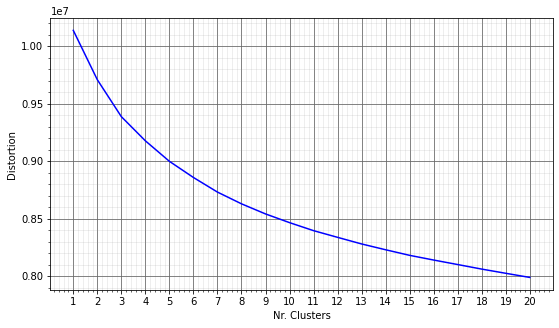

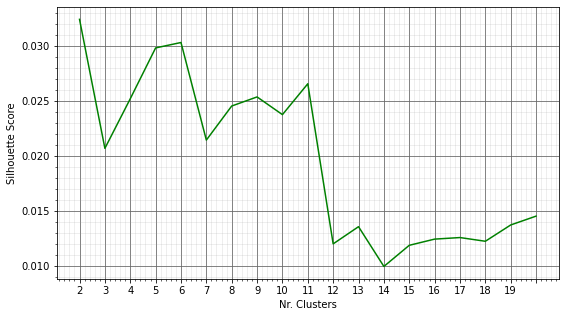

In [ ]:
def plot_values(
        values,
        color='blue', 
        label = 'Distortion', 
        parameter = "Nr. Clusters"
    ):
    
    pyplot.figure(figsize=(9, 5))
    pyplot.plot(values, color=color)
    pyplot.xlabel(parameter)
    pyplot.ylabel(label)
    pyplot.grid(b=True, which='major', color='#666666', linestyle='-')
    pyplot.minorticks_on()
    pyplot.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    if(label == 'Silhouette Score'):
        pyplot.xticks( np.arange(len(values)), range(2,len(values) + 1) )
    else:
        pyplot.xticks( np.arange(len(values)), range(1,len(values) + 1) )

plot_values(distortion_list)
plot_values(sil_scores_list, color = 'green', label = "Silhouette Score")

The number of clusters chosen was 6 because from the value 6 the distortion doesn’t decrease too much with higher numbers of clusters and the value of the silhouette is the second highest one.

In [ ]:
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

NUMBER_CLUSTERS = 6

data_set = (pd.read_csv('gdrive/My Drive/face_embbedings.csv')).to_numpy()

kmeans = KMeans(n_clusters = NUMBER_CLUSTERS, max_iter = 1000, n_jobs = -1, verbose = 1)

kmeans.fit(data_set)

predictions = kmeans.predict(data_set)
data = []

for i in range(0, len(predictions)):
    data.append(["train/" + str(i + 1) + ".jpg", predictions[i]])

data_df = pd.DataFrame(data)

In [ ]:
data_df.to_csv('gdrive/My Drive/6_clusters_face.csv', index = False)

In [ ]:
centroids_list = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids_list)
centroids_df.to_csv('gdrive/My Drive/6_clusters_centers.csv', index = False)

**Cell for the closest images to the culster's centroid**

In [ ]:
from PIL import Image
from IPython.display import display
import pandas as pd
import scipy
from scipy.spatial.distance import cdist

data_df = (pd.read_csv('gdrive/My Drive/face_embbedings.csv')).to_numpy()
centroids_df = pd.read_csv('gdrive/My Drive/6_clusters_centers.csv')


def compute_distances(centroids, data_set, cluster):
    return cdist(centroids[cluster:cluster + 1], data_set,'euclidean')

def show_closest_images(cluster, centroids_df, data_df, nr_images):
    centroids = centroids_df.values

    distances = (compute_distances(centroids, data_df, cluster))[0]

    list_dist = [(distances[i], i) for i in range(0, len(distances))]
    list_dist.sort(key = lambda x: x[0])  
    
    for i in range(0, nr_images):
        filename = 'train/' + str(list_dist[i][1]) + '.jpg'
        display(Image.open('/content/' + filename).convert('RGB'))
    

show_closest_images(1, centroids_df, data_df, nr_images = 10)

# VI. K-means results

Below are some examples with the most representative images for every cluster (the number of clusters chosen was 6).

<img src = 'https://drive.google.com/uc?id=1sg4NvSJMvA2pQjru_5neFAQLQsxw-_lY' width = 500>


# VII. DBSCAN: Density-based Spatial Clustering of Applications with Noise

**DBSCAN** is a unsupervised learning algorithm that creates clusters with points closely grouped, the objective of the algorithm is to find dense clusters and the points outside the clusters are labeled as noise points. The ε-neighborhood of a point p is the set of points that are situated at a distance smaller than ε.
A point p is a core point if it’s ε-neighborhood has at least m points. A point q is a border points if it is in the ε-neighborhood of another point p with p≠q. A point q is directly density-reachable from p if q is a border point of p. A point q is density-reachable from p if there exist a sequence of points starting with p and ending with q and one point is directly density-reachable from the previous point. A point q is density-connected to a point p if there exist a point r such that both points are density-reachable from r.

<img src = 'https://drive.google.com/uc?id=1eMwmo_vqBB17Pcpfje1AGehW-ezx22AN' width = 500>


In [ ]:
import pandas as pd

data_df = (pd.read_csv('gdrive/My Drive/face_embbedings.csv'))
8.24
data_set = data_df.to_numpy()

The following cell must be executed only if you want to normalize the data set.

In [ ]:
mean = np.mean(data_set, axis=0)
std = np.std(data_set, axis=0)

data_set = (data_set - mean)/std

print(data_set.shape)

(86744, 128)


In [ ]:
import numpy as np 
import pandas as pd
from numba import jit, cuda
import sklearn
  
from sklearn.cluster import DBSCAN 

EPSILON = 10.5
M = 5

dbscan = DBSCAN(eps = EPSILON, min_samples = M, n_jobs = -1)
dbscan.fit(data_set)


In [ ]:
from collections import Counter

print(Counter(dbscan.labels_).keys())
print(Counter(dbscan.labels_).values())

dict_keys([0, -1, 19, 1, 2, 8, 10, 31, 3, 4, 5, 15, 6, 38, 35, 16, 7, 9, 48, 11, 12, 49, 53, 26, 13, 41, 25, 14, 17, 22, 52, 18, 23, 20, 21, 24, 40, 27, 28, 29, 30, 47, 32, 33, 51, 34, 37, 50, 42, 36, 39, 45, 46, 44, 43])
dict_values([74905, 11493, 22, 9, 10, 6, 4, 7, 9, 5, 13, 9, 5, 6, 4, 6, 8, 6, 6, 6, 8, 4, 5, 5, 7, 5, 5, 5, 6, 15, 4, 5, 4, 9, 5, 14, 4, 4, 5, 8, 6, 7, 1, 5, 4, 10, 6, 4, 3, 9, 4, 4, 4, 5, 6])


The clusters obtained for different values of the parameters M and Eps. The label -1 means noise point. We can see that in most of the cases there is obtained only one cluster with most of the images and some very small clusters with few images.

M = 10
Eps = 12.
dict_keys([0, -1])
dict_values([86438, 306])

M = 10
Eps = 11.5
dict_keys([0, -1])
dict_values([84960, 1784])

M = 10
Eps = 11.
dict_keys([0, -1, 1])
dict_values([80673, 6058, 13])

M = 5
Eps = 11.
dict_keys([0, -1, 9, 4, 1, 8, 7, 5, 2, 3, 6])
dict_values([81777, 4924, 3, 7, 5, 5, 4, 5, 5, 5, 4])

# VIII. Compute kth distances

To find the best value for the epsilon and M the graph for kth distances was plotted. The best values are ussualy located in the zone in which the graph has the bigest change in curvature.

<img src = 'https://drive.google.com/uc?id=1z2UDwE-lMJnP0uiFVnOkZFnrJO_2tO61' width = 500>


In [ ]:
import pandas as pd
import numpy as np

data_set = (pd.read_csv('gdrive/My Drive/face_embbedings.csv')).to_numpy()



**The kth distances graph was obtained by computting manually all these dsitances batches, to run the algorithm on the entire set of facial embeddings cause the execution to crash because of the memory limit.**

In [ ]:
from matplotlib import pyplot
from numba import jit, cuda
import scipy
from scipy.spatial.distance import cdist

distances_df = pd.DataFrame()

@jit
def compute_kth_dist(data_set, k = 0):
    return cdist(data_set[k:k + 5000], data_set,'euclidean')

@jit
def compute_last_dist(data_set, k = 0):
    return cdist(data_set[k:len(data_set)], data_set,'euclidean')

for K in range(0, 40000, 5000):
    print("Executed for", K, "points")
    distances_list=compute_kth_dist(data_set, k = K)
    distances_df = pd.concat([distances_df, pd.DataFrame((np.sort(distances_list))[:,0:500])])

distances_list=compute_last_dist(data_set, k = 40000)
distances_df = pd.concat([distances_df, pd.DataFrame((np.sort(distances_list))[:,0:500])])

In [ ]:
distances_df.to_csv('gdrive/My Drive/half_500_kth_dist_faces.csv', index = False)

**Plot kth distances**

In [ ]:
distances = (pd.read_csv('gdrive/My Drive/half_500_kth_dist_faces.csv')).to_numpy()

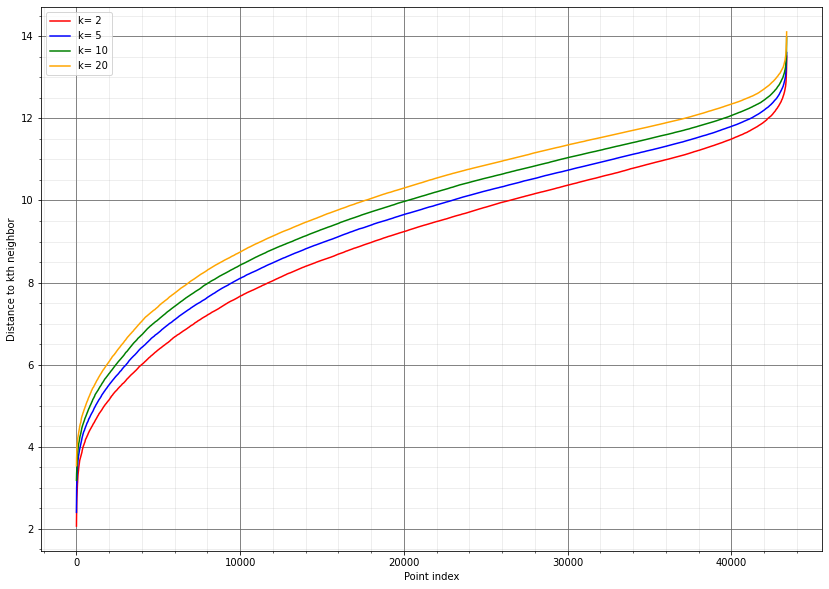

In [ ]:
K_list = [2, 5, 10, 20]
color_list = ['red', 'blue', 'green', 'orange']

pyplot.figure(figsize=(14, 10))
pyplot.xlabel('Point index')
pyplot.ylabel('Distance to kth neighbor')
pyplot.grid(b=True, which='major', color='#666666', linestyle='-')
pyplot.minorticks_on()
pyplot.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

for i in range(0, len(K_list)):
    dists = np.sort(np.transpose(distances[:,(K_list[i]+1)]))
    pyplot.plot(dists, label=('k= ' + str(K_list[i])), color= color_list[i])
    

pyplot.legend()

# IX. Observations on DBSCAN results.

For any value of M and epsilon tried always one cluster with most of the points was obtained. So the DBSCAN algorithm returned only one cluster. The reason for producing only one cluster might be that the dataset is very condensed, this results from the paper where a t-sne visualization was done on the data set. The data set being condensed it means that the DBSCAN algorithm detect only one big dense cluster.

<img src = 'https://drive.google.com/uc?id=1V3-8AxY-jf8C6MqL7qhBRtaTM4b74WlY' width = 1000>

Figure 9.1. The FairFace dataset is very condensed compared to other dataset in the visualization of the data using the t-SNE algorithm, image taken and processed from [1]

# X. Further directions

The K-means algorithms can find some clusters but with high noise inside the clusters, the DBSCAN was used to try to solve the noise issue but tunning parameters is very hard. Another algorithm that could be use is the OPTICS algorithms whish is a generalized DBSCAN implemented to deal with the dificulties in tunning the M and Epsilon parameters.

# References

[1] Kimmo Karkkainen UCLA, Jungseock Joo UCLA, FairFace: Face Attribute Dataset 
for Balanced Race, Gender, and Age https://arxiv.org/pdf/1908.04913.pdf

[2] Florian Schroff Google Inc., Dmitry Kalenichenko Google Inc., James Philbin Google Inc.: FaceNet: A Unified Embedding for Face Recognition and Clustering https://arxiv.org/pdf/1503.03832.pdf

[3] FairFace dataset https://github.com/joojs/fairface 

[4] https://www.learnopencv.com/best-project-award-computer-vision-for-faces/

[5] http://dendroid.sk/2011/05/09/k-means-clustering/

[6] https://stats.stackexchange.com/questions/194734/dbscan-what-is-a-core-point
